# Wikipedia

In [1]:
from urllib.parse import urlencode
import requests
from pymongo import MongoClient
import time
import pandas as pd

## MongoDB Setup

In [2]:
# Creates client with default server and port
client = MongoClient()

# Get database "wikipedia"
db = client.wikipedia

# Get references to *pages* and *categories* collections
mongo_pages = db.pages
mongo_categories = db.categories
mongo_content = db.pages_content

## Download categories and pages from Wikipedia

In [3]:
# https://pt.wikipedia.org/w/api.php?action=query&format=json&list=categorymembers&cmtitle=Category%3AArgentina&cmlimit=200
url_base = 'https://pt.wikipedia.org/w/api.php'
f = { 
    'action': 'query',
    'format': 'json',
    'list': 'categorymembers',
     'cmlimit': '200',
     'cmprop': 'ids|title|type'
}
def parameters_category_members(cmtitle = None, cmpageid = -1):
    fc = f.copy()
    if cmpageid != -1:
        fc['cmpageid'] = cmpageid
    else:
        fc['cmtitle'] = cmtitle
    return fc

def get_url(parameters):
    return f'{url_base}{parameters}'

def get_url_category(cmtitle):
    parameters_argentina = parameters_category_members('Category:Argentina')
    return get_url(urlencode(parameters_argentina))

def get_category(cmtitle = None, cmpageid = -1):
    params_category = parameters_category_members(cmtitle, cmpageid)
    category_r = requests.get(url_base, params=params_category)
    category_content = []
    if category_r.status_code == 200:
        category_content = category_r.json()
    return category_content

def get_category_members(cmtitle = None, cmpageid = -1):
    return get_category(cmtitle=cmtitle, cmpageid=cmpageid)['query']['categorymembers']

## Insert and retrieve data from MongoDB

- Categories status
    * Check: waiting for someone to check if it has to be downloaded
    * Waiting: waiting for dowload
    * Skeep: skeep download of this category
    * Done: downloaded
- Pages status
    * Waiting: waiting for download

In [28]:
def get_categories_for_download():
    waiting_criteria = { 'download': 'Waiting' }
    return list(mongo_categories.find(waiting_criteria))

def add_categories_for_check(categories_for_check):
    add_categories_for_status(categories_for_check, 'Check')

def add_category_for_download(pageid):
    mongo_categories.update_one(
        { "pageid": pageid },
        { "$set": { 'download': 'Waiting' } }
    )

def set_category_done(pageid):
    mongo_categories.update_one(
        { "pageid": pageid },
        { "$set": { 'download': 'Done' } }
    )

def set_category_skeep(pageid):
    set_category_status(pageid, category_status='Skeep')

def set_category_status(pageid, category_status):
    mongo_categories.update_one(
        { "pageid": pageid },
        { "$set": { 'download': category_status } }
    )

def add_categories_for_status(categories_for_status, status):
    if len(categories_for_status) > 0:
        for category_for_status in categories_for_status:
            category_for_status['download'] = status
        mongo_categories.insert_many(categories_for_status)
    
def category_exists(cmpageid):
    return mongo_categories.count_documents({'pageid': cmpageid}) > 0

## Algorithm

In [29]:
def insert_pages(pages, cmpageid, cmtitle):
    if len(pages) > 0:
        for page in pages:
            page['category_id'] = cmpageid
            page['category_title'] = cmtitle
            page['download'] = 'Waiting'
        mongo_pages.insert_many(pages)

def download_subcategories(subcategories):
    if len(subcategories) > 0:
        for subcategory in subcategories:
            download_category_tree(subcategory)

def download_category_tree(category, country):
    # Sleep for 1 second before starting download one category tree
    time.sleep(1)

    cmpageid = category['pageid']
    cmtitle = category["title"]
    print(f'Retrieving pages for category {cmtitle} [{cmpageid}]')
    
    members = get_category_members(cmpageid=cmpageid)
    pages = [m for m in members if m['type'] == 'page']
    for p in pages:
        p['country'] = country
    insert_pages(pages, cmpageid, cmtitle)
    subcats = [m for m in members if m['type'] == 'subcat']
    for s in subcats:
        s['parent'] = cmpageid
        s['country'] = country
    subcats_for_check = [s for s in subcats if not category_exists(s['pageid'])]
    add_categories_for_check(subcats_for_check)
    set_category_done(cmpageid)

### Inicializa todas as subcategorias da principal *Argentina*

In [5]:
members_categories_argentina = get_category_members(cmtitle='Category:Argentina')
pages_argentina = [m for m in members_categories_argentina if m['type'] == 'page']
subcategories_argentina = [m for m in members_categories_argentina if m['type'] == 'subcat']
# add_categories_for_check(subcategories_argentina)

### Inicializa todas as subcategorias da principal Chile

In [8]:
members_categories_chile = get_category_members(cmtitle='Category:Chile')
for mcc in members_categories_chile:
    mcc['country'] = 'Chile'
subcategories_chile = [m for m in members_categories_chile if m['type'] == 'subcat']
# add_categories_for_check(subcategories_chile)

### Inicializa todas as subcategorias da Nova Zelândia

In [46]:
members_categories_nz = get_category_members(cmtitle='Categoria:Nova_Zelândia')
for mcnz in members_categories_nz:
    mcnz['country'] = 'Nova Zelandia'
subcategories_nz = [m for m in members_categories_nz if m['type'] == 'subcat']
# add_categories_for_check(subcategories_nz)

### Inicializa todas as subcategorias dos Estados Unidos

In [16]:
# Categoria:Estados_Unidos
members_categories_usa = get_category_members(cmtitle='Categoria:Estados_Unidos')
for mcusa in members_categories_usa:
    mcusa['country'] = 'Estados Unidos'
subcategories_usa = [m for m in members_categories_usa if m['type'] == 'subcat']
add_categories_for_check(subcategories_usa)

### Marca categorias para download

In [120]:
ids = [5568913, 5600226, 2976735, 3229009, 3228959, 5543207, 206176,3228965, 1935902,3266151,  3572256, 3544176, 1715183, 4852814, 4814502, 2178241,5580178, 3472896,  4814499, 5577558, 2201392]
for id in ids:
    add_category_for_download(pageid=id)

### Executa download das páginas das categorias marcadas para Download

In [121]:
# Busca categorias marcadas para download
categories_for_download = get_categories_for_download()
print(f'{len(categories_for_download)} categoria(s) marcadas para download')

# Faz download de cada categoria
for c in categories_for_download:
    download_category_tree(c, 'Estados Unidos')

21 categoria(s) marcadas para download
Retrieving pages for category Categoria:Corpos de água do Alasca [5568913]
Retrieving pages for category Categoria:Arquipélagos do Alasca [5600226]
Retrieving pages for category Categoria:Baías do Alasca [2976735]
Retrieving pages for category Categoria:Cabos do Alasca [3229009]
Retrieving pages for category Categoria:Estreitos do Alasca [3228959]
Retrieving pages for category Categoria:Golfos e baías do Alasca [5543207]
Retrieving pages for category Categoria:Ilhas do Alasca [206176]
Retrieving pages for category Categoria:Penínsulas do Alasca [3228965]
Retrieving pages for category Categoria:Rios do Alasca [1935902]
Retrieving pages for category Categoria:Vulcões do Alasca [3266151]
Retrieving pages for category Categoria:California Trail [3572256]
Retrieving pages for category Categoria:Oregon Trail [3544176]
Retrieving pages for category Categoria:Vale da Morte [1715183]
Retrieving pages for category Categoria:Parque Nacional da Sequoia [48528

### Analisar categorias para Check

In [122]:
for_skeep = []
if (len(for_skeep) > 0):
    for sk in for_skeep:
        set_category_skeep(sk)

for_check = list(mongo_categories.find({ 'download': 'Check', 'country': 'Estados Unidos'}))

# usa = [5577536, 3203291, 2403918, 2671885, 4914662, 4400845, 3439705, 4149018,2739967, 4133805, 2739980, 5589663, 4133798]
usa_4_check = [(fc['pageid'], fc['title']) for fc in for_check]

In [19]:
usa = [3003786, 2966383, 2511655, 2541119, 3166610]

### Backup do que já foi feito download

In [131]:
# Categorias
categories = list(mongo_categories.find())
categories_df = pd.DataFrame(categories)
categories_df.to_csv('categories.csv')

In [132]:
pages = list(mongo_pages.find())
pages_df = pd.DataFrame(pages)
pages_df.to_csv('pages.csv')

In [61]:
pages_df.shape

(498, 8)

### Verificar categorias e páginas sem country

In [37]:
# Pages
pages_no_country = list(db.pages.find({"country": {"$exists": False }}))
print(f'{len(pages_no_country)} pages found with no country')

# Categories
categories_no_country = list(db.categories.find({"country": {"$exists": False }}))
print(f'{len(categories_no_country)} categories found with no country')

0 pages found with no country
0 categories found with no country


### Corrigir categorias e paginas dos Estados Unidos marcadas como Nova Zelandia

In [26]:
nz = list(mongo_categories.find({ 'country': 'Nova Zelandia'}))

nz_with_usa = [c for c in nz if "Estados Unidos" in c['title']]
for cat_fix in nz_with_usa:
    mongo_categories.update_one(
        { '_id': cat_fix['_id']},
        { '$set': { 'country': 'Estados Unidos'}}
    )

In [41]:
nz = list(mongo_pages.find({ 'country': 'Nova Zelandia'}))
nz_with_usa = [c for c in nz if "Estados Unidos" in c['title']]

for pag_fix in nz_with_usa:
    mongo_pages.update_one(
        { '_id': pag_fix['_id']},
        { '$set': { 'country': 'Estados Unidos'}}
    )

In [129]:
nz = list(mongo_pages.find({ 'country': 'Nova Zelandia'}))
nz_with_usa = [c for c in nz if "Estados Unidos" in c['category_title']]

for pag_fix in nz_with_usa:
    mongo_pages.update_one(
        { '_id': pag_fix['_id']},
        { '$set': { 'country': 'Estados Unidos'}}
    )

## Download de páginas

In [65]:
url_base = 'https://pt.wikipedia.org/w/api.php'

def get_pages_for_download(limite=100):
    return list(mongo_pages.find({ 'download': 'Waiting' }).limit(limite))

def get_pages_for_text_download(limite=100):
    return list(mongo_content.find({ 'download_text': 'Waiting' }).limit(limite))

def get_pages_downloads_counts():
    return list(mongo_pages.aggregate([
        { '$group': { '_id': '$download', 'total': { '$sum': 1 } } }
    ]))

def get_pages_text_downloads_counts():
    return list(mongo_pages.aggregate([
        { '$group': { '_id': '$download_text', 'total': { '$sum': 1 } } }
    ]))

# https://en.wikipedia.org/w/api.php?action=parse&format=json&pageid=3276454&prop=wikitext&formatversion=2
f_page = { 
    'action': 'parse',
    'format': 'json',
    'formatversion': '2'
}

def parameters_wikitext(pageid):
    fc = f_page.copy()
    fc['pageid'] = pageid
    fc['prop'] = 'wikitext'
    return fc

def parameters_text(pageid):
    fc = f_page.copy()
    fc['pageid'] = pageid
    fc['prop'] = 'text'
    return fc

def get_wikitext(pageid):
    params_wikitext = parameters_wikitext(pageid)
    wikitext_r = requests.get(url_base, params=params_wikitext)
    wikitext_content = {}
    if wikitext_r.status_code == 200:
        wikitext_content = wikitext_r.json()
    else:
        print(f'Erro ao fazer download de wikitext de pagina {pageid}')
    return wikitext_content

def get_text(pageid):
    params_text = parameters_text(pageid)
    text_r = requests.get(url_base, params=params_text)
    text_content = {}
    if text_r.status_code == 200:
       text_content = text_r.json()
    else:
        print(f'Erro ao fazer download de text de pagina {pageid}')
    return text_content

def copy_page_with_wikitext(page):
    p_wikitext = page.copy()
    p_wikitext['wikitext'] = get_wikitext(page['pageid'])['parse']['wikitext']
    return p_wikitext

# get_pages_for_download()[0]

### Download page wikitexts

In [5]:
def run_wikitext_download(amount_wikitext):
    pages_for_wikitext_download = get_pages_for_download(amount_wikitext)
    current = 1
    for page in pages_for_wikitext_download:
        page_wikitext = copy_page_with_wikitext(page)
        del page_wikitext['_id']
        mongo_content.insert_one(page_wikitext)
        mongo_pages.update_many(
            { 'pageid': page['pageid'] },
            { '$set': { 'download': 'Done' }}
        )
        print(f'Page [{page["pageid"]}]({page["title"]}) downloaded successfuly ({current} of {amount_wikitext})')
        current = current + 1
        time.sleep(2)

# run_wikitext_download(100)

ntes Uinta) downloaded successfuly (445 of 737)
Page [4202100](Cordilheira Wasatch) downloaded successfuly (446 of 737)
Page [344031](Parque Nacional do Grand Canyon) downloaded successfuly (447 of 737)
Page [1749897](Cordilheira do Alasca) downloaded successfuly (448 of 737)
Page [4201510](Cordilheira Aleutiana) downloaded successfuly (449 of 737)
Page [5700682](Montanhas Chigmit) downloaded successfuly (450 of 737)
Page [5949882](Montes Chugach) downloaded successfuly (451 of 737)
Page [1749927](Montanhas Costeiras) downloaded successfuly (452 of 737)
Page [2457040](Montes Kenai) downloaded successfuly (453 of 737)
Page [4300385](Montanhas de Santo Elias) downloaded successfuly (454 of 737)
Page [2557819](Montes Wrangell) downloaded successfuly (455 of 737)
Page [196346](Black Hills) downloaded successfuly (456 of 737)
Page [3501598](Cordilheira Wyoming) downloaded successfuly (457 of 737)
Page [2852043](Cordilheira Teton) downloaded successfuly (458 of 737)
Page [3544078](Cordilheir

In [26]:
def show_download_statistics():
    pdc = get_pages_downloads_counts()
    print(f'Page download counts: {pdc}')
    pages_wikitext_counts = mongo_content.count_documents({})
    print(f'Pages with wikitext: {pages_wikitext_counts}')
# show_download_statistics()

### Download page texts

In [66]:
def set_pages_for_text_download():
    mongo_pages.update_many(
        { 'download': 'Done' },
        { '$set': { 'download_text': 'Waiting' } }
    )
set_pages_for_text_download()

In [90]:
def run_text_download(amount_text):
    current = 1
    pages_text = mongo_pages.find({ 'download_text': 'Waiting' }).limit(amount_text)

    for pc in pages_text:
        pageid = pc['pageid']
        text = get_text(pageid)
        mongo_content.update_one(
            { 'pageid': pageid },
            { '$set': { 'text': text } }
        )
        mongo_pages.update_one(
            { 'pageid': pageid },
            { '$set': { 'download_text': 'Done' } }
        )
        print(f'Page text [{pc["pageid"]}]({pc["title"]}) downloaded successfuly ({current} of {amount_text})')
        current = current + 1
        time.sleep(2)

In [70]:
def show_text_download_statistics():
    pdc = get_pages_text_downloads_counts()
    print(f'Page text download counts: {pdc}')

In [96]:
run_text_download(303)
show_text_download_statistics()

 [1356940](Lazy Mountain) downloaded successfuly (31 of 303)
Page text [1356937](Levelock) downloaded successfuly (32 of 303)
Page text [1356934](Lime Village) downloaded successfuly (33 of 303)
Page text [1356930](Livengood) downloaded successfuly (34 of 303)
Page text [1356927](Lowell Point) downloaded successfuly (35 of 303)
Page text [1356924](Lower Kalskag) downloaded successfuly (36 of 303)
Page text [1356921](Lutak) downloaded successfuly (37 of 303)
Page text [1356912](Manley Hot Springs) downloaded successfuly (38 of 303)
Page text [1356909](Manokotak) downloaded successfuly (39 of 303)
Page text [1356906](Marshall (Alasca)) downloaded successfuly (40 of 303)
Page text [1385249](McCarthy (Alasca)) downloaded successfuly (41 of 303)
Page text [1356918](McGrath (Alasca)) downloaded successfuly (42 of 303)
Page text [1356915](McKinley Park) downloaded successfuly (43 of 303)
Page text [1356902](Meadow Lakes) downloaded successfuly (44 of 303)
Page text [1356899](Mekoryuk) downloa

In [19]:
pcs = list(mongo_content.aggregate(
    [ 
        { '$group': { '_id': '$pageid', 'total': { '$sum': 1 } } }
    ]
))

2252 3097


In [24]:
dobrado = [p for p in pcs if p['total'] > 1]


In [42]:
def find_distinct_pages():
    return list(mongo_pages.aggregate(
        [ 
            { '$group': { '_id': '$pageid', 'total': { '$sum': 1 } } },
            { '$sort': { 'total': -1 }}
        ]
    ))

def count_distinct_pages():
    return len(find_distinct_pages())

print(f'We have downloaded {count_distinct_pages()} distinct pages')

We have downloaded 2252 distinct pages


In [39]:
list(mongo_pages.find({ 'pageid': 158914 }))

[{'_id': ObjectId('60b3743cf25e4f45f45ff669'),
  'pageid': 158914,
  'ns': 0,
  'title': 'Ojos del Salado',
  'type': 'page',
  'category_id': 575725,
  'category_title': 'Categoria:Montanhas da Argentina',
  'download': 'Done',
  'country': 'Argentina'},
 {'_id': ObjectId('60b3743ff25e4f45f45ff683'),
  'pageid': 158914,
  'ns': 0,
  'title': 'Ojos del Salado',
  'type': 'page',
  'category_id': 1134166,
  'category_title': 'Categoria:Vulcões da Argentina',
  'download': 'Waiting',
  'country': 'Argentina'},
 {'_id': ObjectId('60bca1e26b45e1b4a9a89aee'),
  'pageid': 158914,
  'ns': 0,
  'title': 'Ojos del Salado',
  'type': 'page',
  'country': 'Chile',
  'category_id': 5302400,
  'category_title': 'Categoria:Pontos extremos do Chile',
  'download': 'Waiting'},
 {'_id': ObjectId('60bca4fd6b45e1b4a9a89ca2'),
  'pageid': 158914,
  'ns': 0,
  'title': 'Ojos del Salado',
  'type': 'page',
  'country': 'Chile',
  'category_id': 737679,
  'category_title': 'Categoria:Montanhas do Chile',
  '

In [31]:
pages_dobrado = [p for p in pcs if p['total'] > 1]
pages_dobrado[0]

{'_id': 237330, 'total': 2}

In [33]:
list(mongo_pages.find({'pageid': 237330}))

[{'_id': ObjectId('60bca3806b45e1b4a9a89b25'),
  'pageid': 237330,
  'ns': 0,
  'title': 'Cauquenes (província)',
  'type': 'page',
  'country': 'Chile',
  'category_id': 913225,
  'category_title': 'Categoria:!Esboços sobre geografia do Chile',
  'download': 'Done'},
 {'_id': ObjectId('60bca4f56b45e1b4a9a89c2e'),
  'pageid': 237330,
  'ns': 0,
  'title': 'Cauquenes (província)',
  'type': 'page',
  'country': 'Chile',
  'category_id': 232966,
  'category_title': 'Categoria:Províncias do Chile',
  'download': 'Waiting'}]

## Correção collection pages

- Problema: a mesma página tinha sido baixada mais de uma vez porque era referenciada por várias coleções
- Solução
    * Renomear collection pages para pages_incorreto (feito no mongo shell)
    * Recriar a collection pages com estrutura correta
        * A categoria agora será um objeto com id e título ao invés de estes valores estarem soltos na páginas. Assim ficará melhor estuturado
        * O objeto da página terá uma collection de categorias. Cada página lida da estrutura antiga terá na nova collection um array com as categorias que a referenciam
    * Renomear pages_content para pages_content incorreto

In [3]:
mongo_pages_incorreto = db.pages_incorreto

In [4]:
# Obtem todas paginas de collection incorreta
todas_paginas_incorreto = list(mongo_pages_incorreto.find({}))

In [5]:
# Corrigir categoria das paginas incorretas. Cria objeto para categoria e coloca id e titulo
for pagina_incorreto in todas_paginas_incorreto:
    category = {
        'category_id': pagina_incorreto['category_id'],
        'category_title': pagina_incorreto['category_title']
    }
    pagina_incorreto['category'] = category
    del pagina_incorreto['category_id']
    del pagina_incorreto['category_title']

In [6]:
# Dictionario que mapeia uma pageid para documento da pagina
agregado_paginas_incorreto = {}

for pagina_incorreto in todas_paginas_incorreto:
    pageid_incorreto = pagina_incorreto['pageid']
    if pageid_incorreto in agregado_paginas_incorreto:
        existente = agregado_paginas_incorreto[pageid_incorreto]
        existente['categories'].append(pagina_incorreto['category'])
    else:
        pagina_incorreto['categories'] = [pagina_incorreto['category']]
        agregado_paginas_incorreto[pageid_incorreto] = pagina_incorreto
    del pagina_incorreto['category']


In [22]:
# Insere as páginas corrigidas no mongo
paginas_agregadas = list(agregado_paginas_incorreto.values())
mongo_pages.insert_many(paginas_agregadas)

In [23]:
# Conta páginas para ver o resultado
mongo_pages.count_documents({})

2252

In [24]:
# Marcar todas as páginas na collection de pages para refazer download
mongo_pages.update_many(
    {},
    { '$set': { 'download': 'Waiting' } }
)

In [25]:
# Referencia para collection com conteudo incorreto
mongo_content_incorreto = db.pages_content_incorreto

In [35]:
def fix_wikitext_download(amount_wikitext):
    pages_for_wikitext_download = get_pages_for_download(amount_wikitext)
    current = 1

    for page in pages_for_wikitext_download:
        # Verifica se esta ja foi baixada antes
        found_wikitext = False
        pages_wikitext_incorreto = mongo_content_incorreto.find({'pageid': page['pageid']})

        for pwi in pages_wikitext_incorreto:
            wikitext_incorreto = pwi.get('wikitext')
            if wikitext_incorreto:
                page['wikitext'] = wikitext_incorreto
                mongo_content.insert_one(page)
                found_wikitext = True
                mongo_pages.update_one(
                    { 'pageid': page['pageid'] },
                    { '$set': { 'download': 'Done' }}
                )
                break

        if found_wikitext:
            print(f'Page [{page["pageid"]}]({page["title"]}) Fixed successfuly ({current} of {amount_wikitext})')
        else:
            print(f'Page [{page["pageid"]}]({page["title"]}) has not been downloaded yet')

        current = current + 1

In [51]:
fix_wikitext_download(52)
show_download_statistics()

Page [3648137](Fort Astoria) Fixed successfuly (1 of 52)
Page [3546212](Fort Kearny) Fixed successfuly (2 of 52)
Page [3917707](Montanhas Blue (Oregon)) Fixed successfuly (3 of 52)
Page [3546927](Mullan Road) Fixed successfuly (4 of 52)
Page [3273627](Oregon Trail) Fixed successfuly (5 of 52)
Page [3917731](Passo Lolo (Oregon)) Fixed successfuly (6 of 52)
Page [3848113](Peoria Party) Fixed successfuly (7 of 52)
Page [3678933](Robert Stuart (explorador)) Fixed successfuly (8 of 52)
Page [3848141](Elijah White) Fixed successfuly (9 of 52)
Page [4570981](Greed) Fixed successfuly (10 of 52)
Page [1633474](Rochas deslizantes de Racetrack Playa) Fixed successfuly (11 of 52)
Page [5796208](Bacia de Badwater) Fixed successfuly (12 of 52)
Page [6252450](Above Diamond) Fixed successfuly (13 of 52)
Page [420561](General Sherman (árvore)) Fixed successfuly (14 of 52)
Page [5228187](Illacme tobini) Fixed successfuly (15 of 52)
Page [6253200](Presidente (árvore)) Fixed successfuly (16 of 52)
Page [1

## Análise documentos download

In [54]:
import seaborn as sns
import pandas as pd

### Análise wikitext

In [49]:
pcs = list(mongo_content.find({}))

In [52]:
lengths_wikitext = [len(pc['wikitext']) for pc in pcs]
df = pd.DataFrame(lengths_wikitext, columns=['Length'])
df.head()

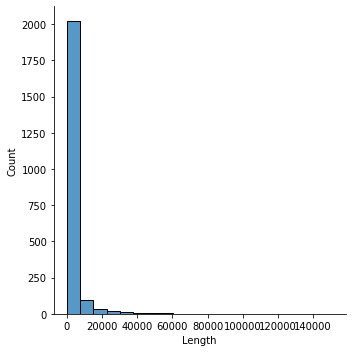

In [59]:
sns.displot(df, x='Length', bins=20)

In [60]:
# Verificando se todas as páginas srealmente têm conteúdo
df['Length'].describe()

count      2200.000000
mean       3700.394545
std        8867.133667
min         109.000000
25%         920.750000
50%        1760.500000
75%        3165.500000
max      150898.000000
Name: Length, dtype: float64

## Fix downloaded text

- It was stored in the documents the whole structure of the answer
- It should store only the ext

In [109]:
pcs = list(mongo_content.find({}))
for pc in pcs:
    mongo_content.update_one(
        { 'pageid': pc['pageid'] },
        { '$set': { 'text': pc['text']['parse']['text'] } }
    )

### Análise text

In [110]:
pcs = list(mongo_content.find({}))

In [111]:
lengths_text = [len(pc['text']) for pc in pcs]
df = pd.DataFrame(lengths_text, columns=['Length'])
df.head()

,Length
0,140685
1,33027
2,46988
3,34210
4,35169


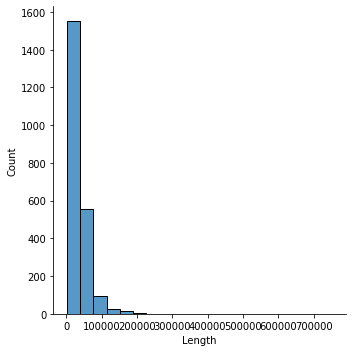

In [112]:
sns.displot(df, x='Length', bins=20)

In [113]:
# Verificando se todas as páginas srealmente têm conteúdo
df['Length'].describe()

count      2252.000000
mean      34514.032860
std       37499.394246
min         799.000000
25%       13731.250000
50%       30754.000000
75%       41868.250000
max      753196.000000
Name: Length, dtype: float64